# MIA attacks on Length-of-Stay predictor, Gated Recurrent Unit with Decay (GRU-D)
## Installation of Packages in Conda

To install the required packages in your conda environment, you can use the following commands:

```bash
conda install h5py
conda install pytables

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys

from torch import zeros

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

from utils.data_processing import get_mimic_dataloaders, get_mimic_dataset

The  `batch_size` is one of the parameters which is assigned based on hyperparameter tuning as detailed in [this notebook](https://github.com/MLforHealth/MIMIC_Extract/blob/4daf3c89be7de05d26f47819d68d5532de6f753a/notebooks/Baselines%20for%20Mortality%20and%20LOS%20prediction%20-%20GRU-D.ipynb).

In [3]:
# Generate the dataset and dataloaders
path = os.path.join(os.getcwd(), "data/")

train_frac = 0.4
valid_frac = 0.0
test_frac = 0.0
early_stop_frac = 0.4
batch_size = 74
use_LR = False # True if you want to use the LR model, False if you want to use the GRUD model

dataset, train_indices, validation_indices, test_indices, early_stop_indices= get_mimic_dataset(path,
                                                                            train_frac ,
                                                                            valid_frac,
                                                                            test_frac,
                                                                            early_stop_frac,
                                                                            use_LR)

Loading dataset...
Loaded dataset from /home/fazeleh/LeakPro/examples/mia/LOS/data/GRUD_data/dataset.pkl


In [4]:
train_loader, validation_loader, test_loader, early_stop_loader = get_mimic_dataloaders(dataset,
                                                            train_indices,
                                                            validation_indices,
                                                            test_indices,
                                                            early_stop_indices,
                                                            batch_size)

The `optimized_hyperparams` is assigned based on hyperparameter tuning as detailed in [this notebook](https://github.com/MLforHealth/MIMIC_Extract/blob/4daf3c89be7de05d26f47819d68d5532de6f753a/notebooks/Baselines%20for%20Mortality%20and%20LOS%20prediction%20-%20GRU-D.ipynb).

In [12]:
optimized_hyperparams ={
    "hidden_size": 27,
    "learning_rate": 0.0001,
    "num_epochs":40,
    "patience_early_stopping": 40,
    "patience_lr_scheduler": 2,
    "batch_size": 74,
    "seed": 6286,
    "min_delta": 0.00001,
    }
n_features = int(dataset.x.shape[1]/3)
X_mean = zeros(1,dataset.x.shape[2],n_features)

model_params = {k: optimized_hyperparams[k] for k in [ "hidden_size", "batch_size"]}

# Add other required parameters to model_params
model_params.update({
    "input_size": n_features,
    "X_mean": X_mean,
    "output_last": False
})

In [13]:
from utils.model_grud import *

# Initialize the model with filtered parameters
model = GRUD(**model_params)

# Train the model with Train_Model function
train_losses, test_losses , train_acc, test_acc = gru_trained_model_and_metadata(model,
                                                                                train_loader,
                                                                                early_stop_loader,
                                                                                epochs = optimized_hyperparams["num_epochs"],
                                                                                patience_early_stopping = optimized_hyperparams["patience_early_stopping"],
                                                                                patience_lr= optimized_hyperparams["patience_lr_scheduler"],
                                                                                min_delta = optimized_hyperparams["min_delta"],
                                                                                learning_rate = optimized_hyperparams["learning_rate"])

Model Structure:  GRUD(
  (zl): Linear(in_features=235, out_features=27, bias=True)
  (rl): Linear(in_features=235, out_features=27, bias=True)
  (hl): Linear(in_features=235, out_features=27, bias=True)
  (gamma_x_l): FilterLinear(in_features=104, out_features=104, bias=True)
  (gamma_h_l): Linear(in_features=104, out_features=27, bias=True)
  (fc): Linear(in_features=27, out_features=2, bias=True)
  (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.2, inplace=False)
)
Start Training ... 
Output type dermined by the model


Training Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Training Progress:   2%|▎         | 1/40 [00:07<04:56,  7.59s/it]

Epoch 0: Validation loss improved to 0.6755
Learning Rate: 0.000100000000
Epoch: 0, train_loss: 0.77142452, valid_loss: 0.6755281


Training Progress:   5%|▌         | 2/40 [00:15<04:49,  7.62s/it]

Epoch 1: Validation loss improved to 0.6480
Learning Rate: 0.000100000000
Epoch: 1, train_loss: 0.70990286, valid_loss: 0.64802595


Training Progress:   8%|▊         | 3/40 [00:22<04:41,  7.62s/it]

Epoch 2: Validation loss improved to 0.6375
Learning Rate: 0.000100000000
Epoch: 2, train_loss: 0.68575445, valid_loss: 0.6375039


Training Progress:  10%|█         | 4/40 [00:30<04:34,  7.61s/it]

Epoch 3: Validation loss improved to 0.6306
Learning Rate: 0.000100000000
Epoch: 3, train_loss: 0.67221655, valid_loss: 0.63060581


Training Progress:  12%|█▎        | 5/40 [00:38<04:26,  7.60s/it]

Epoch 4: Validation loss improved to 0.6263
Learning Rate: 0.000100000000
Epoch: 4, train_loss: 0.6663743, valid_loss: 0.62629236


Training Progress:  15%|█▌        | 6/40 [00:45<04:18,  7.60s/it]

Epoch 5: Validation loss improved to 0.6234
Learning Rate: 0.000100000000
Epoch: 5, train_loss: 0.65855825, valid_loss: 0.62342111


Training Progress:  18%|█▊        | 7/40 [00:53<04:10,  7.60s/it]

Epoch 6: No improvement. Patience counter: 1/40
Learning Rate: 0.000100000000
Epoch: 6, train_loss: 0.65072195, valid_loss: 0.62361345


Training Progress:  20%|██        | 8/40 [01:00<04:03,  7.60s/it]

Epoch 7: Validation loss improved to 0.6228
Learning Rate: 0.000100000000
Epoch: 7, train_loss: 0.65277301, valid_loss: 0.62277012


Training Progress:  22%|██▎       | 9/40 [01:08<03:55,  7.59s/it]

Epoch 8: Validation loss improved to 0.6224
Learning Rate: 0.000100000000
Epoch: 8, train_loss: 0.64107054, valid_loss: 0.62238655


Training Progress:  25%|██▌       | 10/40 [01:15<03:47,  7.58s/it]

Epoch 9: Validation loss improved to 0.6214
Learning Rate: 0.000100000000
Epoch: 9, train_loss: 0.63568287, valid_loss: 0.62143204


Training Progress:  28%|██▊       | 11/40 [01:23<03:39,  7.58s/it]

Epoch 10: No improvement. Patience counter: 1/40
Learning Rate: 0.000100000000
Epoch: 10, train_loss: 0.63023297, valid_loss: 0.62200899


Training Progress:  30%|███       | 12/40 [01:31<03:32,  7.58s/it]

Epoch 11: No improvement. Patience counter: 2/40
Learning Rate: 0.000100000000
Epoch: 11, train_loss: 0.62372054, valid_loss: 0.62250409


Training Progress:  32%|███▎      | 13/40 [01:38<03:24,  7.59s/it]

Epoch 12: No improvement. Patience counter: 3/40
Learning Rate: 0.000020000000
Epoch: 12, train_loss: 0.62312966, valid_loss: 0.62408618


Training Progress:  35%|███▌      | 14/40 [01:46<03:17,  7.59s/it]

Epoch 13: No improvement. Patience counter: 4/40
Learning Rate: 0.000020000000
Epoch: 13, train_loss: 0.61365205, valid_loss: 0.62479363


Training Progress:  38%|███▊      | 15/40 [01:53<03:09,  7.60s/it]

Epoch 14: No improvement. Patience counter: 5/40
Learning Rate: 0.000020000000
Epoch: 14, train_loss: 0.61150404, valid_loss: 0.62496369


Training Progress:  40%|████      | 16/40 [02:01<03:02,  7.60s/it]

Epoch 15: No improvement. Patience counter: 6/40
Learning Rate: 0.000004000000
Epoch: 15, train_loss: 0.61046561, valid_loss: 0.62524198


Training Progress:  42%|████▎     | 17/40 [02:09<02:54,  7.61s/it]

Epoch 16: No improvement. Patience counter: 7/40
Learning Rate: 0.000004000000
Epoch: 16, train_loss: 0.61262291, valid_loss: 0.62539906


Training Progress:  45%|████▌     | 18/40 [02:16<02:47,  7.60s/it]

Epoch 17: No improvement. Patience counter: 8/40
Learning Rate: 0.000004000000
Epoch: 17, train_loss: 0.61028987, valid_loss: 0.62536747


Training Progress:  48%|████▊     | 19/40 [02:24<02:39,  7.61s/it]

Epoch 18: No improvement. Patience counter: 9/40
Learning Rate: 0.000000800000
Epoch: 18, train_loss: 0.61096002, valid_loss: 0.62536713


Training Progress:  50%|█████     | 20/40 [02:31<02:32,  7.61s/it]

Epoch 19: No improvement. Patience counter: 10/40
Learning Rate: 0.000000800000
Epoch: 19, train_loss: 0.60783245, valid_loss: 0.62539858


Training Progress:  52%|█████▎    | 21/40 [02:39<02:24,  7.61s/it]

Epoch 20: No improvement. Patience counter: 11/40
Learning Rate: 0.000000800000
Epoch: 20, train_loss: 0.60612318, valid_loss: 0.62541465


Training Progress:  55%|█████▌    | 22/40 [02:47<02:17,  7.62s/it]

Epoch 21: No improvement. Patience counter: 12/40
Learning Rate: 0.000000160000
Epoch: 21, train_loss: 0.61198717, valid_loss: 0.62543615


Training Progress:  57%|█████▊    | 23/40 [02:54<02:09,  7.62s/it]

Epoch 22: No improvement. Patience counter: 13/40
Learning Rate: 0.000000160000
Epoch: 22, train_loss: 0.60663263, valid_loss: 0.62544265


Training Progress:  60%|██████    | 24/40 [03:02<02:01,  7.61s/it]

Epoch 23: No improvement. Patience counter: 14/40
Learning Rate: 0.000000160000
Epoch: 23, train_loss: 0.60631481, valid_loss: 0.62544579


Training Progress:  62%|██████▎   | 25/40 [03:10<01:53,  7.60s/it]

Epoch 24: No improvement. Patience counter: 15/40
Learning Rate: 0.000000032000
Epoch: 24, train_loss: 0.60956054, valid_loss: 0.62544693


Training Progress:  65%|██████▌   | 26/40 [03:17<01:46,  7.59s/it]

Epoch 25: No improvement. Patience counter: 16/40
Learning Rate: 0.000000032000
Epoch: 25, train_loss: 0.61014141, valid_loss: 0.62544855


Training Progress:  68%|██████▊   | 27/40 [03:25<01:38,  7.58s/it]

Epoch 26: No improvement. Patience counter: 17/40
Learning Rate: 0.000000032000
Epoch: 26, train_loss: 0.61104354, valid_loss: 0.62544953


Training Progress:  70%|███████   | 28/40 [03:32<01:30,  7.58s/it]

Epoch 27: No improvement. Patience counter: 18/40
Learning Rate: 0.000000006400
Epoch: 27, train_loss: 0.60807777, valid_loss: 0.62545027


Training Progress:  72%|███████▎  | 29/40 [03:40<01:23,  7.56s/it]

Epoch 28: No improvement. Patience counter: 19/40
Learning Rate: 0.000000006400
Epoch: 28, train_loss: 0.60957477, valid_loss: 0.62545051


Training Progress:  75%|███████▌  | 30/40 [03:47<01:15,  7.56s/it]

Epoch 29: No improvement. Patience counter: 20/40
Learning Rate: 0.000000006400
Epoch: 29, train_loss: 0.60896124, valid_loss: 0.62545067


Training Progress:  78%|███████▊  | 31/40 [03:55<01:07,  7.55s/it]

Epoch 30: No improvement. Patience counter: 21/40
Learning Rate: 0.000000006400
Epoch: 30, train_loss: 0.61144581, valid_loss: 0.62545094


Training Progress:  80%|████████  | 32/40 [04:02<01:00,  7.53s/it]

Epoch 31: No improvement. Patience counter: 22/40
Learning Rate: 0.000000006400
Epoch: 31, train_loss: 0.60545864, valid_loss: 0.62545105


Training Progress:  82%|████████▎ | 33/40 [04:10<00:52,  7.54s/it]

Epoch 32: No improvement. Patience counter: 23/40
Learning Rate: 0.000000006400
Epoch: 32, train_loss: 0.60758751, valid_loss: 0.62545123


Training Progress:  85%|████████▌ | 34/40 [04:17<00:45,  7.53s/it]

Epoch 33: No improvement. Patience counter: 24/40
Learning Rate: 0.000000006400
Epoch: 33, train_loss: 0.61511705, valid_loss: 0.62545147


Training Progress:  88%|████████▊ | 35/40 [04:25<00:37,  7.54s/it]

Epoch 34: No improvement. Patience counter: 25/40
Learning Rate: 0.000000006400
Epoch: 34, train_loss: 0.6090028, valid_loss: 0.62545152


Training Progress:  90%|█████████ | 36/40 [04:32<00:30,  7.53s/it]

Epoch 35: No improvement. Patience counter: 26/40
Learning Rate: 0.000000006400
Epoch: 35, train_loss: 0.60815305, valid_loss: 0.62545168


Training Progress:  92%|█████████▎| 37/40 [04:40<00:22,  7.57s/it]

Epoch 36: No improvement. Patience counter: 27/40
Learning Rate: 0.000000006400
Epoch: 36, train_loss: 0.6094342, valid_loss: 0.62545175


Training Progress:  95%|█████████▌| 38/40 [04:48<00:15,  7.58s/it]

Epoch 37: No improvement. Patience counter: 28/40
Learning Rate: 0.000000006400
Epoch: 37, train_loss: 0.6070953, valid_loss: 0.62545183


Training Progress:  98%|█████████▊| 39/40 [04:55<00:07,  7.58s/it]

Epoch 38: No improvement. Patience counter: 29/40
Learning Rate: 0.000000006400
Epoch: 38, train_loss: 0.6074793, valid_loss: 0.62545199


Training Progress: 100%|██████████| 40/40 [05:03<00:00,  7.58s/it]

Epoch 39: No improvement. Patience counter: 30/40
Learning Rate: 0.000000006400
Epoch: 39, train_loss: 0.60438335, valid_loss: 0.62545215


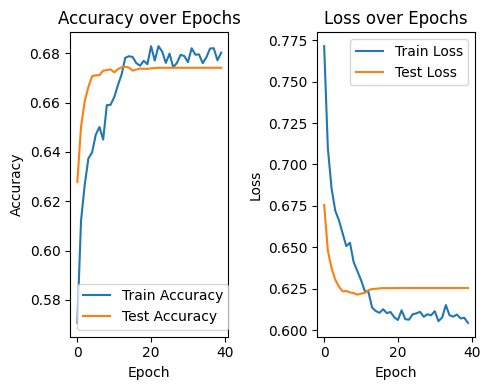

In [14]:
import matplotlib.pyplot as plt

# Convert losses to numpy-compatible lists directly
train_losses_cpu = [float(loss) for loss in train_losses]
test_losses_cpu = [float(loss) for loss in test_losses]

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(test_acc, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
print("Train Accuracy: ", train_acc)
print("Test Accuracy: ", test_acc)

Train Accuracy:  [0.6230552365041244, 0.643312101910828, 0.6586613762138457, 0.6658661376213846, 0.6815286624203821, 0.6946851832515402, 0.6965646862274198, 0.7079461209146914, 0.7040826981309387, 0.7053357001148585, 0.711078625874491, 0.7112874595384776, 0.715359715986217, 0.7141067140022972, 0.7149420486582437, 0.7078417040826981, 0.7144199644982772, 0.7111830427064842, 0.7128537120183773, 0.7131669625143573, 0.7119139605304375, 0.7057533674428318, 0.7125404615223974, 0.7104521248825311, 0.7124360446904041, 0.7111830427064842, 0.7093035397306046, 0.7149420486582437, 0.7151508823222303, 0.7128537120183773, 0.7097212070585779, 0.7063798684347917, 0.7125404615223974, 0.7114962932024642, 0.7133757961783439, 0.7142111308342904, 0.7124360446904041, 0.7096167902265845, 0.7124360446904041, 0.7101388743865511]
Test Accuracy:  [0.6685809752532108, 0.6725488148689569, 0.6631512999895584, 0.6660749712853712, 0.6652396366294246, 0.6649263861334447, 0.6625247989975984, 0.6614806306776653, 0.662002

##  Attacking the GRUD model
Modify ```audit.yaml ``` file to attack GRUD model: 
  
  ```
  module_path: "utils/model_grud.py" 
  model_class: "GRUD"
  target_folder: "./target_GRUD"
  data_path: "./data/unflattened/dataset.pkl"
  ```

In [9]:
from mimic_gru_handler import MimicInputHandlerGRU

from leakpro import LeakPro

# Read the config file
config_path = "audit.yaml"

# Prepare leakpro object
leakpro = LeakPro(MimicInputHandlerGRU, config_path)

# Run the audit
mia_results = leakpro.run_audit(return_results=True)

2025-02-17 19:21:03,498 INFO     Target model blueprint created from GRUD in utils/model_grud.py.
2025-02-17 19:21:03,506 INFO     Loaded target model metadata from ./target_GRUD/model_metadata.pkl
/home/fazeleh/LeakPro/leakpro/input_handler/handler_setup.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case wher

## Report Genrating

In [10]:

# Import and initialize ReportHandler
from leakpro.reporting.report_handler import ReportHandler

# report_handler = ReportHandler()
report_handler = ReportHandler(report_dir="./leakpro_output/results")

# Save MIA resuls using report handler
for res in mia_results:
    report_handler.save_results(attack_name=res.attack_name, result_data=res, config=res.configs)

2025-02-17 19:55:17,404 INFO     Initializing report handler...
2025-02-17 19:55:17,405 INFO     report_dir set to: ./leakpro_output/results
2025-02-17 19:55:17,405 INFO     Saving results for rmia


<Figure size 640x480 with 0 Axes>

In [11]:

# # Create the report by compiling the latex text
report_handler.create_report()

2025-02-17 19:55:27,515 INFO     No results of type GIAResults found.
2025-02-17 19:55:27,517 INFO     No results of type SinglingOutResults found.
2025-02-17 19:55:27,517 INFO     No results of type InferenceResults found.
2025-02-17 19:55:27,517 INFO     No results of type LinkabilityResults found.
2025-02-17 19:55:32,778 INFO     PDF compiled


<Figure size 640x480 with 0 Axes>